#### Visualization for EUMETSAT/MSG Data

In [1]:
import autoroot

In [2]:
import os
import ast
import eumdac
import datetime
import shutil
import pyproj
import rioxarray
import rasterio
import xarray as xr
import matplotlib.pyplot as plt

from pyproj import CRS

In [3]:
%load_ext autoreload
%autoreload 2

Unfortunately, .nat files are a bit complicated to read/load. One of the best packages is satpy, which then allows loading the files using xarray.

In [4]:
from satpy import Scene
scn = Scene(reader="seviri_l1b_native", filenames=['MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA.nat'])

In [5]:
# MSG data contains 12 channels, including the high-resolution visible (HRV) channel.
datasets = scn.available_dataset_names()
datasets

['HRV',
 'IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

In order to convert the scn object to xarray, each dataset needs to be loaded.

In [6]:
scn.load(datasets[1:], generate=False, calibration='radiance') # The calibration is set to 'radiance' to convert the data to radiance units
# Note: The HRV channel comes in 1 km resolution, while the other channels are 3 km resolution.
# Because of the size mismatch, the HRV channel would either need to be downscaled,
# or it needs to the loaded separetely to the other channels


/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning

In [7]:
ds = scn.to_xarray()

/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/satpy/cf/coords.py:201: UserWarning: Cannot pretty-format "acq_time" coordinates because they are not identical among the given datasets
  _warn_if_pretty_but_not_unique(pretty, coord_name)


In [8]:
ds.WV_073

<xarray.DataArray 'WV_073' (y: 3712, x: 3712)>
dask.array<clip, shape=(3712, 3712), dtype=float32, chunksize=(928, 3712), chunktype=numpy.ndarray>
Coordinates: (12/15)
    IR_016_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
  * y                (y) float64 -5.566e+06 -5.563e+06 ... 5.566e+06 5.569e+06
  * x                (x) float64 5.566e+06 5.563e+06 ... -5.566e+06 -5.569e+06
    longitude        (y, x) float64 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    latitude         (y, x) float64 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_039_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    ...               ...
    IR_120_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    IR_134_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS006_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS008_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_062_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_073_acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
Attributes: (12/15)
    calibration:              radiance
    end_time:                 2021-11-10 08:15:00
    georef_offset_corrected:  true
    grid_mapping:             msg_seviri_fes_3km
    modifiers:                []
    orbital_parameters:       {"projection_longitude": 0.0, "projection_latit...
    ...                       ...
    sensor:                   seviri
    standard_name:            toa_outgoing_radiance_per_unit_wavenumber
    start_time:               2021-11-10 08:00:00
    time_parameters:          {"nominal_start_time": "2021-11-10 08:00:00", "...
    units:                    mW m-2 sr-1 (cm-1)-1
    wavelength:               7.35 µm (6.85-7.85 µm)

In [9]:
ds.WV_073.attrs

{'calibration': 'radiance',
 'end_time': '2021-11-10 08:15:00',
 'georef_offset_corrected': 'true',
 'grid_mapping': 'msg_seviri_fes_3km',
 'modifiers': [],
 'orbital_parameters': '{"projection_longitude": 0.0, "projection_latitude": 0.0, "projection_altitude": 35785831.0, "satellite_nominal_longitude": 0.0, "satellite_nominal_latitude": 0.0, "satellite_actual_longitude": -0.3394201003380397, "satellite_actual_latitude": 0.3537999733591259, "satellite_actual_altitude": 35783787.81506324}',
 'platform_name': 'Meteosat-11',
 'reader': 'seviri_l1b_native',
 'resolution': 3000.403165817,
 'sensor': 'seviri',
 'standard_name': 'toa_outgoing_radiance_per_unit_wavenumber',
 'start_time': '2021-11-10 08:00:00',
 'time_parameters': '{"nominal_start_time": "2021-11-10 08:00:00", "nominal_end_time": "2021-11-10 08:15:00", "observation_start_time": "2021-11-10 08:00:10.065000", "observation_end_time": "2021-11-10 08:12:42.766000"}',
 'units': 'mW m-2 sr-1 (cm-1)-1',
 'wavelength': '7.35\xa0µm\xa0(

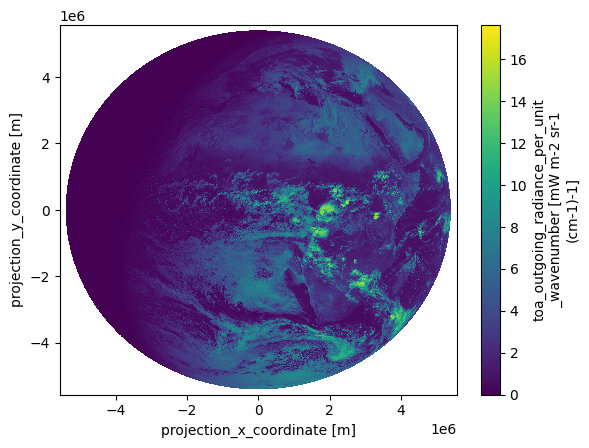

In [49]:
ds.VIS006.plot()

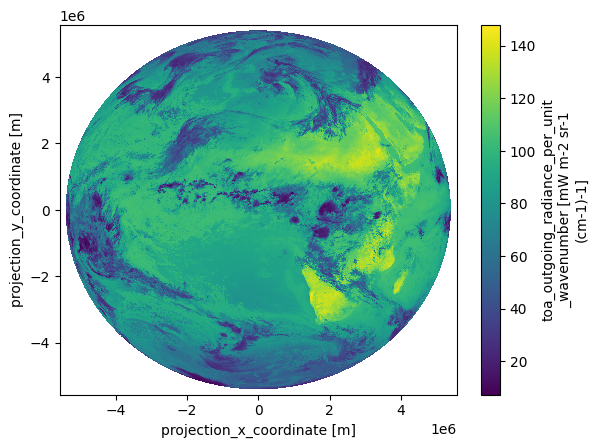

In [50]:
ds.IR_108.plot()

MSG Data is provided in mW m-2 sr-1 (cm-1)-1 and needs to be converted into W m-2 sr-1 um-1 to match the other data sources

In [43]:
cf = 1E-3 * 1E4

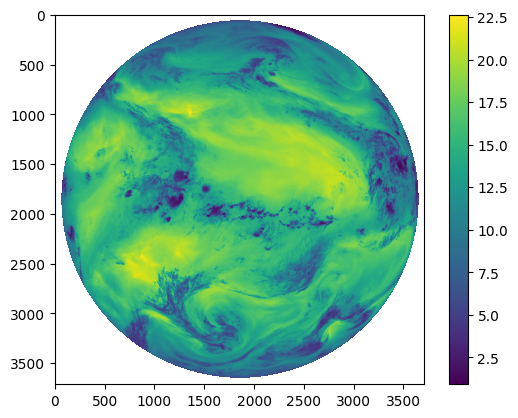

In [46]:
plt.imshow(ds.WV_073.data.compute())
plt.colorbar()

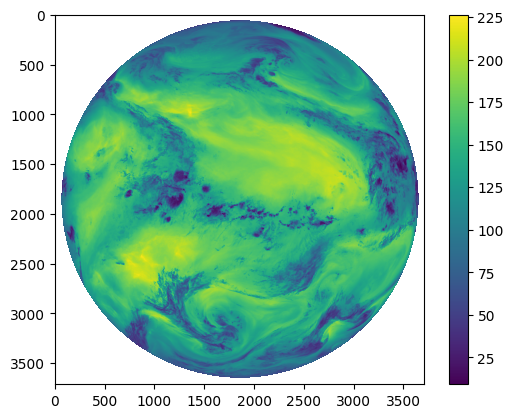

In [47]:
plt.imshow(ds.WV_073.data.compute() * cf)
plt.colorbar()

### Check unit conversions

In [17]:
from rs_tools._src.geoprocessing.utils import convert_units

In [18]:
from rs_tools import MSG_WAVELENGTHS

In [19]:
MSG_WAVELENGTHS

{'IR_016': 1.64,
 'IR_039': 3.92,
 'IR_087': 8.7,
 'IR_097': 9.66,
 'IR_108': 10.8,
 'IR_120': 12.0,
 'IR_134': 13.4,
 'VIS006': 0.64,
 'VIS008': 0.81,
 'WV_062': 6.25,
 'WV_073': 7.35}

In [24]:
ds = ds.drop_vars([k for k in ds.data_vars if k not in MSG_WAVELENGTHS])

In [25]:
ds_units = convert_units(ds, wavelengths=MSG_WAVELENGTHS)

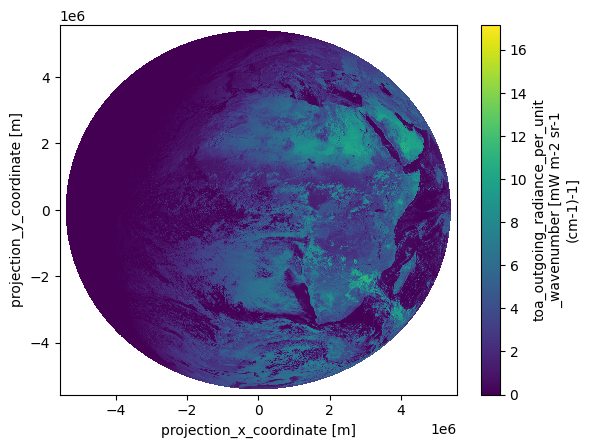

In [12]:
ds.IR_016.plot()

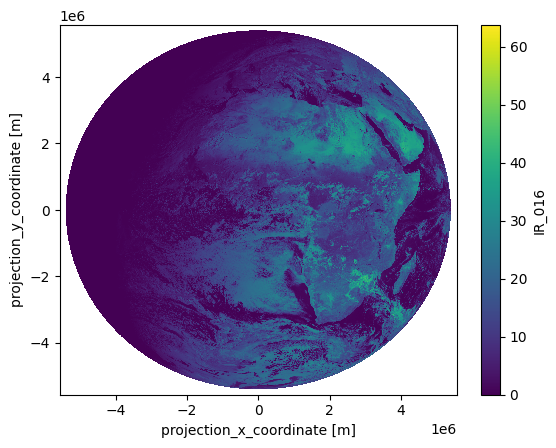

In [26]:
ds_units.IR_016.plot()